In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
#from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
from sklearn import datasets, linear_model
import seaborn as sn
import statsmodels.api as sm
import scipy.stats as st
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['heart.csv']


In [2]:
hrt = pd.read_csv('../input/heart.csv')
X = hrt.iloc[:,:-1]
y = hrt['target']

In [3]:
hrt.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [4]:
hrt.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
corr = hrt.corr()

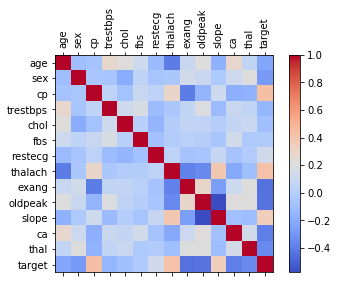

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(0,len(hrt.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hrt.columns)
ax.set_yticklabels(hrt.columns)
plt.show()

In [7]:

st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols=hrt.columns[:-1]
model=sm.Logit(hrt.target,hrt[cols])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.351932
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  303
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                           12
Date:                Fri, 31 May 2019   Pseudo R-squ.:                  0.4893
Time:                        20:39:39   Log-Likelihood:                -106.64
converged:                       True   LL-Null:                       -208.82
                                        LLR p-value:                 4.088e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0128      0.019      0.670      0.503      -0.025       0.050
sex           -1.6381      0.452     -3.625      0.000      -2.524      -0.752
cp             0.8490      0.184      4.613      0.000       0.488       1.210
trestbps      -0.0153      0.010     -1.562      0.118      -0.035       0.004
chol          -0.0036      0.004     -0.960      0.337      -0.011       0.004
fbs           -0.0115      0.526     -0.022      0.983      -1.042       1.019
restecg        0.5432      0.342      1.589      0.112      -0.127       1.213
thalach        0.0319      0.008      3.779      0.000       0.015       0.048
exang         -0.8920      0.403     -2.215      0.027      -1.681      -0.103
oldpeak       -0.4988      0.209     -2.381      0.017      -0.909      -0.088
slope          0.6092      0.346      1.761      0.078      -0.069       1.287
ca            -0.7725      0.189     -4.080      0.000      -1.144      -0.401
thal          -0.8438      0.287     -2.937      0.003      -1.407      -0.281
==============================================================================
"""

In [8]:
def back_feature_elem (data_frame,dep_var,col_list):
    """ Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(hrt,hrt.target,cols)

In [9]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))


         CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
sex          0.112623       0.551073    0.249126   0.001
cp           1.559575       3.088655    2.194764   0.000
thalach      1.017567       1.035326    1.026408   0.000
exang        0.173839       0.758508    0.363123   0.007
oldpeak      0.342750       0.682775    0.483757   0.000
ca           0.352232       0.692750    0.493973   0.000
thal         0.252918       0.697612    0.420046   0.001


In [10]:
new_dat = hrt.drop(['age','trestbps','chol','fbs','restecg','slope'],axis = 1 )
y = hrt['target']
X = new_dat.iloc[:,:-1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (227, 7)
Number transactions y_train dataset:  (227,)
Number transactions X_test dataset:  (76, 7)
Number transactions y_test dataset:  (76,)


In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
model.score(X_train,y_train)

0.9691629955947136

In [14]:
model.score(X_test,y_test)

0.8552631578947368

In [15]:
prediction_rf= model.predict(X_test)

In [16]:
from sklearn import metrics


              precision    recall  f1-score   support

           0       0.88      0.81      0.84        36
           1       0.84      0.90      0.87        40

   micro avg       0.86      0.86      0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



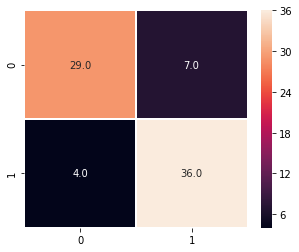

In [17]:
results_rf=metrics.classification_report(y_true=y_test, y_pred=prediction_rf)
print(results_rf)

rf_2=metrics.confusion_matrix(y_true=y_test, y_pred=prediction_rf)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(rf_2, annot=True, linewidths=.5, fmt= '.1f',ax=ax);